In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib
import seaborn as sns

from aau2v.config import ModelConfig, TrainerConfig
from aau2v.dataset_center import load_dataset_center, to_full_meta_value
from aau2v.trainer import PyTorchTrainer
from aau2v.model import load_model
from aau2v.layer import attention_weight, cosine_similarity
from aau2v import util

In [2]:
model_config = ModelConfig(
    max_embedding_norm=5,
)
trainer_config = TrainerConfig(
    dataset_name="movielens",
    model_name="aau2v",
    load_dataset=False,
    save_dataset=False,
    ignore_saved_model=True,
    epochs=5,
)

In [3]:
dataset_center = load_dataset_center(
    dataset_name=trainer_config.dataset_name,
    dataset_dir=trainer_config.dataset_dir,
    load_dataset=trainer_config.load_dataset,
    save_dataset=trainer_config.save_dataset,
    window_size=model_config.window_size,
    data_dir="../data/"
)

create dataset
num_seq: 6040, num_item: 3706, num_item_meta: 28, num_seq_meta: 30, num_item_meta_types: 3, num_seq_meta_types: 3


In [4]:
model = load_model(
    dataset_center=dataset_center,
    trainer_config=trainer_config,
    model_config=model_config
)

trainer = PyTorchTrainer(
    model=model,
    dataset_center=dataset_center,
    trainer_config=trainer_config,
    model_config=model_config,
)
trainer.fit()

100%|██████████| 9207/9207 [02:25<00:00, 63.25it/s]


train 0.004755901127769018


100%|██████████| 1728/1728 [00:08<00:00, 193.34it/s]


valid 0.004517475313899218
saved model to cache/model/movielens/aau2v.pt


100%|██████████| 9207/9207 [02:14<00:00, 68.27it/s]


train 0.004711150829953885


100%|██████████| 1728/1728 [00:08<00:00, 214.50it/s]


valid 0.004784358917680163
saved model to cache/model/movielens/aau2v.pt


100%|██████████| 9207/9207 [02:31<00:00, 60.91it/s]


train 0.004731965136153989


100%|██████████| 1728/1728 [00:08<00:00, 197.19it/s]


valid 0.00472208940664207
saved model to cache/model/movielens/aau2v.pt


100%|██████████| 9207/9207 [02:29<00:00, 61.39it/s]


train 0.00467843741705119


100%|██████████| 1728/1728 [00:09<00:00, 189.44it/s]


valid 0.00469819836085967
saved model to cache/model/movielens/aau2v.pt


100%|██████████| 9207/9207 [02:28<00:00, 62.21it/s]


train 0.004613157649679983


100%|██████████| 1728/1728 [00:09<00:00, 189.90it/s]

valid 0.004588359979167347
saved model to cache/model/movielens/aau2v.pt


{'train': [0.004755901127769018,
  0.004711150829953885,
  0.004731965136153989,
  0.00467843741705119,
  0.004613157649679983],
 'valid': [0.004517475313899218,
  0.004784358917680163,
  0.00472208940664207,
  0.00469819836085967,
  0.004588359979167347]}

In [5]:
seq_embedding = {
    seq_name: e_seq
    for seq_name, e_seq in zip(dataset_center.seq_le.classes_, model.seq_embedding)
}
item_embedding = {
    item_name: e_item
    for item_name, e_item in zip(dataset_center.item_le.classes_, model.item_embedding)
}
seq_meta_embedding = {
    seq_meta_name: e_seq_meta
    for seq_meta_name, e_seq_meta in zip(
        dataset_center.seq_meta_le.classes_,
        model.seq_meta_embedding,
    )
}
item_meta_embedding = {
    item_meta_name: e_item_meta
    for item_meta_name, e_item_meta in zip(
        dataset_center.item_meta_le.classes_,
        model.item_meta_embedding,
    )
}

In [6]:
def visualize_heatmap(
    data: np.ndarray,
    seq_keys: list[str],
    item_keys: list[str],
    figsize: tuple[float, float] = (12, 8),
    annot: bool = False,
    cbar: bool = True,
    cmap: str = "OrRd",
) -> tuple[matplotlib.figure.Figure, matplotlib.axes.Axes]:
    fig = plt.figure(figsize=figsize)
    ax = sns.heatmap(
        data,
        linewidth=0.2,
        xticklabels=item_keys,
        yticklabels=seq_keys,
        annot=annot,
        cmap=cmap,
        cbar=cbar,
    )
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    return fig, ax


def calc_similarity(a: torch.Tensor, b: torch.Tensor, method: str = "inner-product") -> torch.Tensor:
    match method:
        case "attention":
            sim: torch.Tensor = attention_weight(a, b)
        case "cos":
            sim = cosine_similarity(a, b)
        case "inner-product":
            sim = torch.matmul(a, b.T)
        case _:
            raise ValueError(f"Invalid method for calc_similarity: {method}")
    return sim.squeeze()

def analyze_seq(
    seq_index: int,
    method: str = "inner-product",
) -> pd.DataFrame:
    """
    系列seq_index固有の埋め込み表現と補助情報の埋め込み表現の、要素の補助情報に対する類似度を全て求める

    Args:
        seq_index (int): 対象の系列の番号
        method (str): 類似度の求め方    Defaults to "inner-product"
        num_top_values (int): 使用する項目の数  Defaults to 5
        verbose (bool): 詳細を表示するかどうか  Defaults to True

    Returns:
        pd.DataFrame: 系列seq_indexの要素の補助情報に対する類似度
    """
    item_meta_indices = list(range(dataset_center.num_item_meta))
    seq_id = dataset_center.seq_le.inverse_transform([seq_index])[0]
    seq_meta_dict = dataset_center.seq_metadata[seq_id]
    seq_meta_names = [
        to_full_meta_value(name, value) for name, value in seq_meta_dict.items()
    ]
    seq_meta_indices = dataset_center.seq_meta_le.transform(seq_meta_names)

    e_seq = model.seq_embedding[seq_index]
    e_item_metas = model.item_meta_embedding[item_meta_indices]

    item_meta_names = dataset_center.item_meta_le.classes_

    result = []

    weights = calc_similarity(e_seq, e_item_metas, method)
    result += [
        (weight.item(), seq_id, item_meta_name)
        for weight, item_meta_name in zip(weights, item_meta_names)
    ]

    for seq_meta_index, seq_meta_name in zip(seq_meta_indices, seq_meta_names):
        e_seq_meta = model.seq_meta_embedding[seq_meta_index]
        weights = calc_similarity(e_seq_meta, e_item_metas, method)
        result += [
            (weight.item(), seq_meta_name, item_meta_name)
            for weight, item_meta_name in zip(weights, item_meta_names)
        ]

    result = sorted(result)[::-1]
    return pd.DataFrame(result, columns=["similarity", "seq", "item"])

In [7]:
plt.rcParams["font.size"] = 16

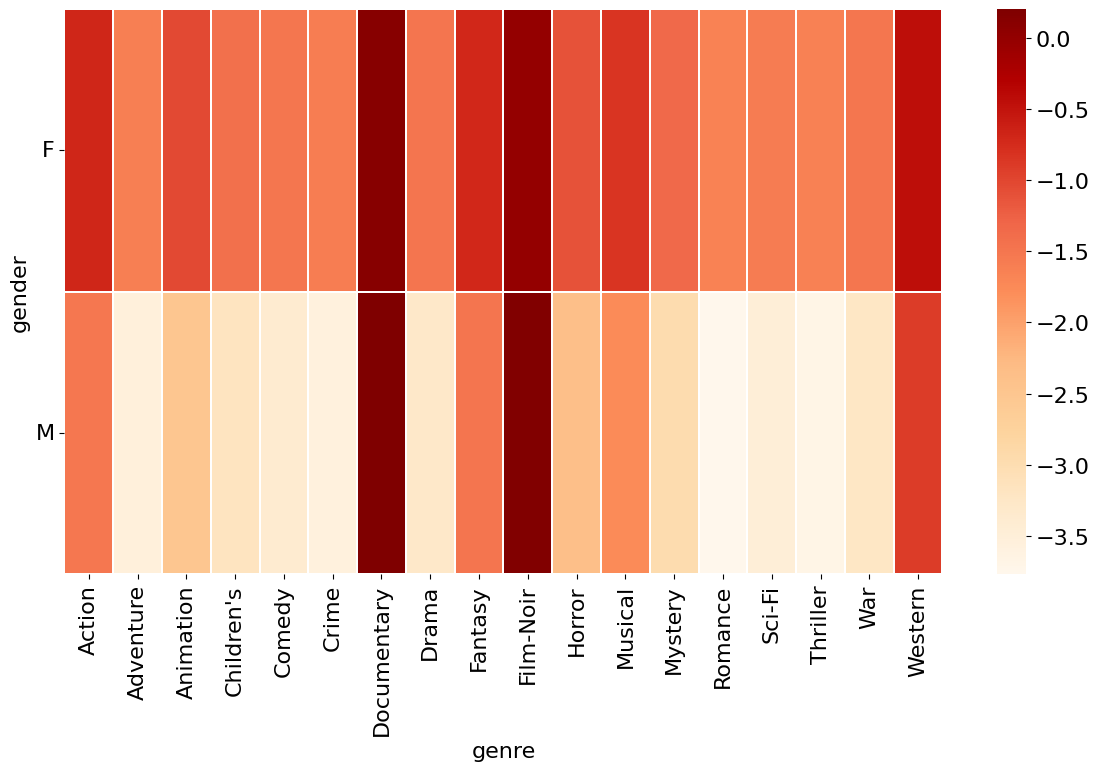

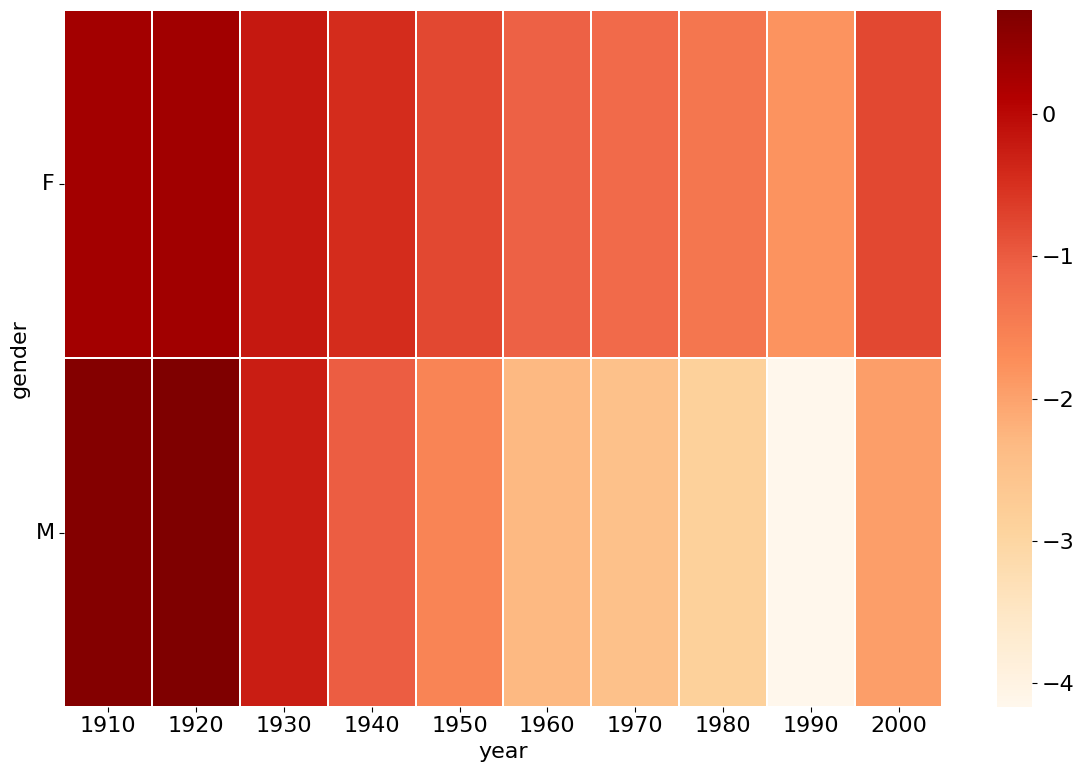

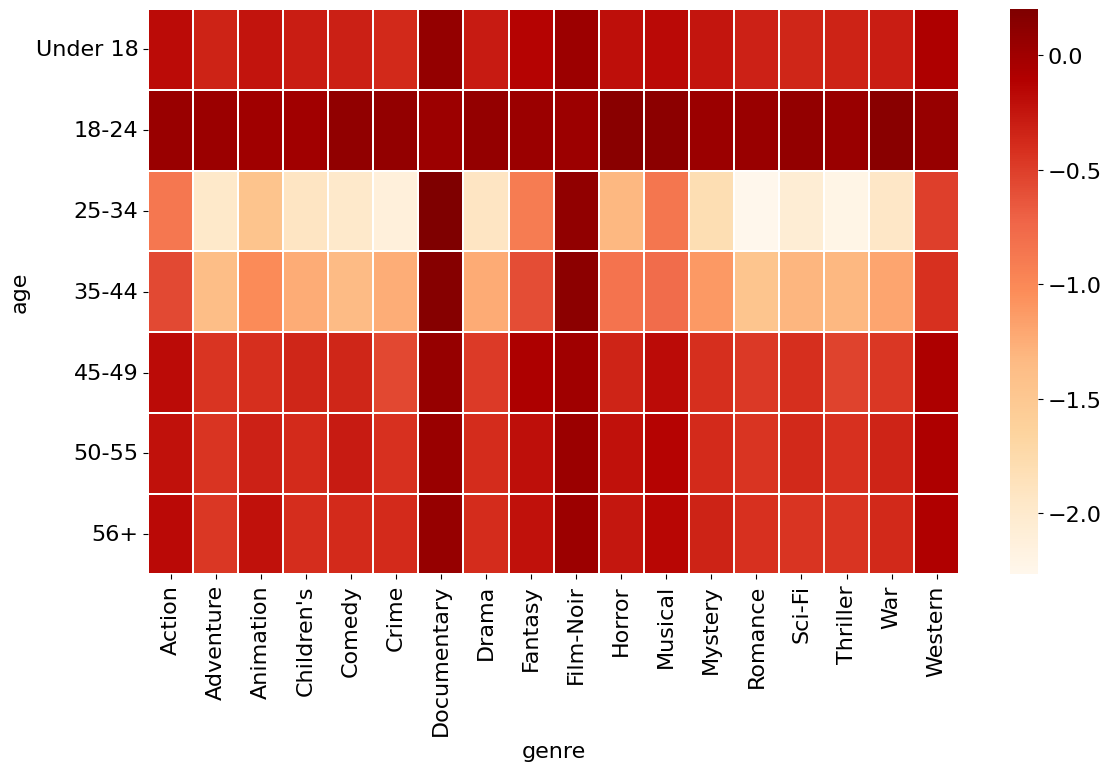

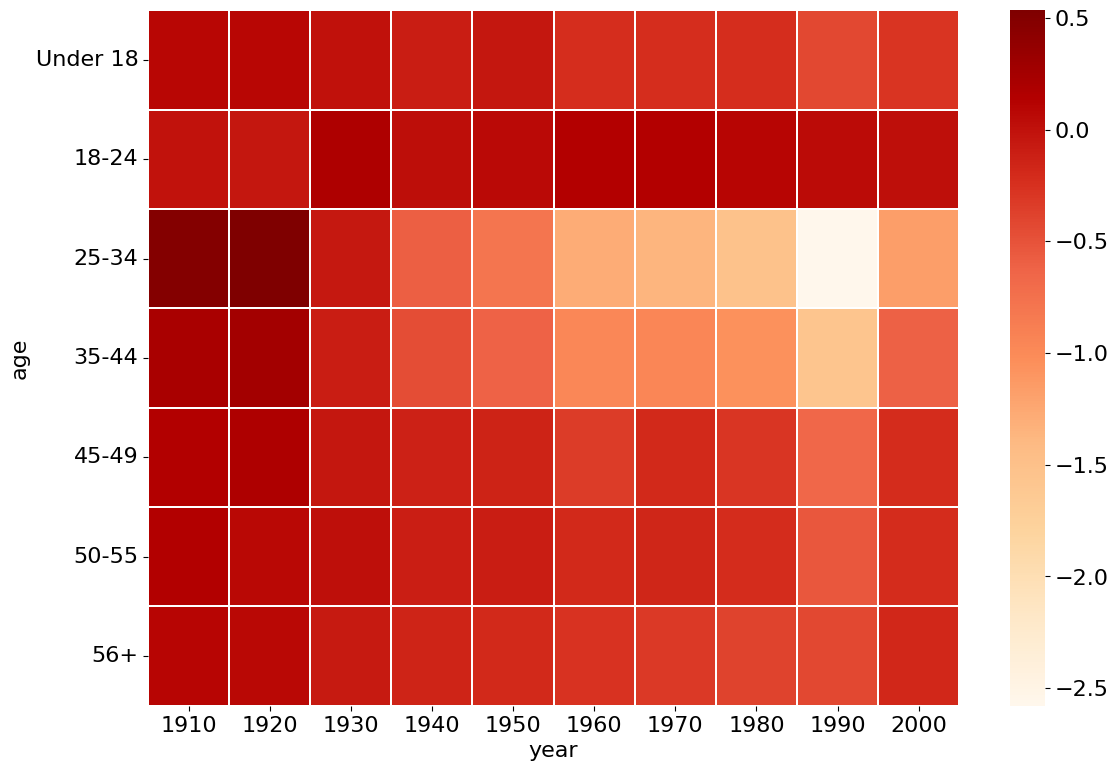

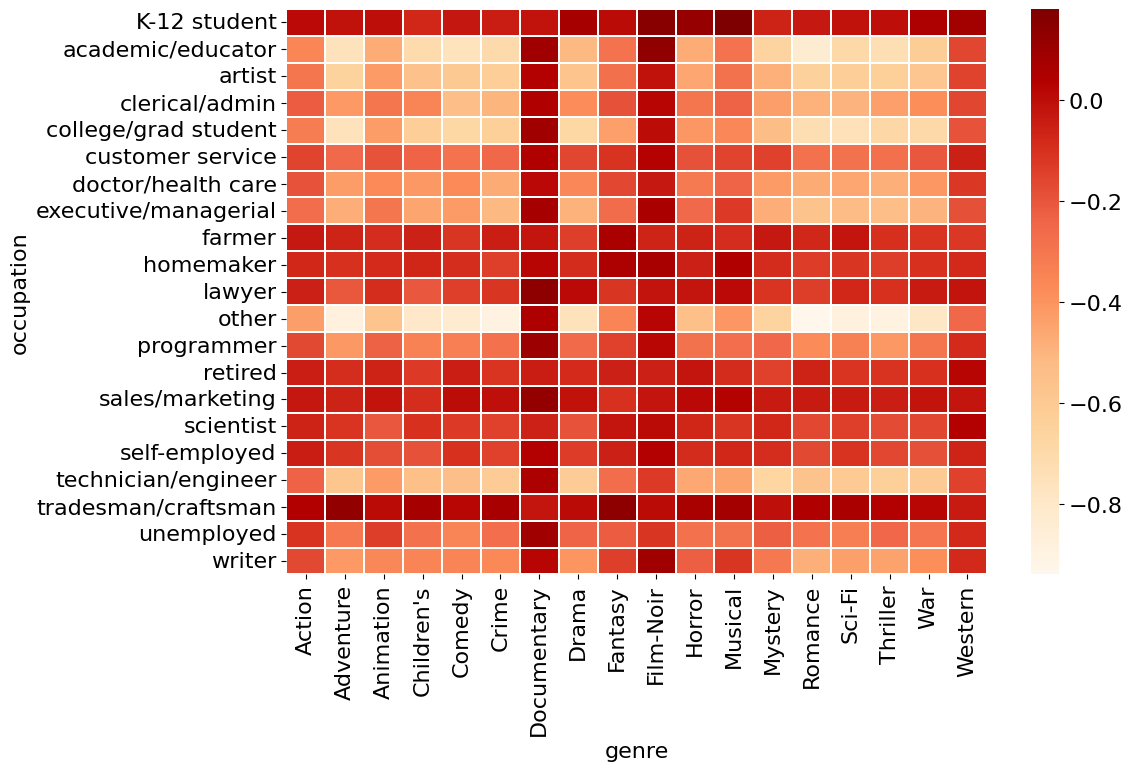

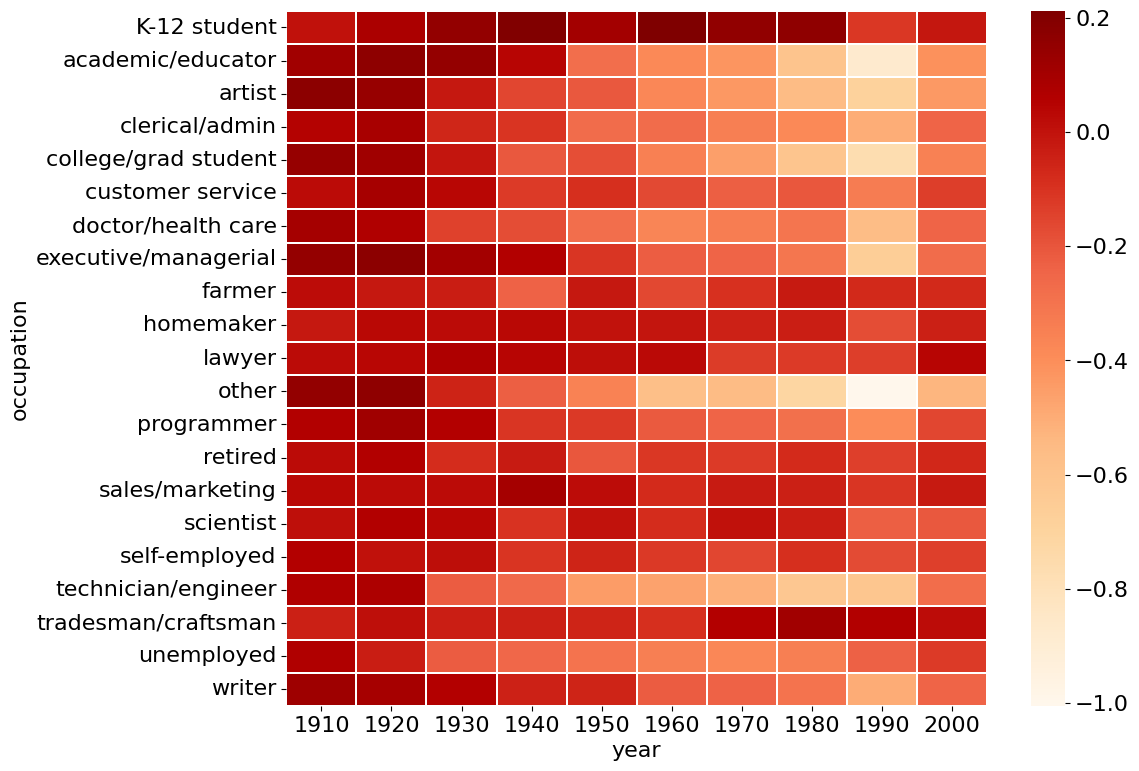

In [9]:
for seq_meta_name in [
    "gender",
    "age",
    "occupation",
]:
    for item_meta_name in [
        "genre",
        "year"
    ]:
        seq_meta_names = sorted([
            to_full_meta_value(seq_meta_name, e)
            for e in dataset_center.seq_meta_dict[seq_meta_name]
        ])
        if seq_meta_name == "age":
            seq_meta_names = ["age:Under 18", "age:18-24", "age:25-34", "age:35-44", "age:45-49", "age:50-55", "age:56+"]
        item_meta_names = sorted([
            to_full_meta_value(item_meta_name, e)
            for e in dataset_center.item_meta_dict[item_meta_name]
        ])

        data = np.zeros((len(seq_meta_names), len(item_meta_names)))
        for i, seq_key in enumerate(seq_meta_names):
            for j, item_key in enumerate(item_meta_names):
                data[i][j] = torch.dot(seq_meta_embedding[seq_key], item_meta_embedding[item_key])

        seq_keys = sorted(dataset_center.seq_meta_dict[seq_meta_name])
        item_keys = sorted(dataset_center.item_meta_dict[item_meta_name])
        if seq_meta_name == "age":
            seq_keys = ["Under 18", "18-24", "25-34", "35-44", "45-49", "50-55", "56+"]

        fig, ax = visualize_heatmap(
            data,
            seq_keys,
            item_keys,
        )
        ax.set_ylabel(seq_meta_name)
        ax.set_xlabel(item_meta_name)

        fig.tight_layout()
        fig.savefig(f"./data/fig_heatmap_{seq_meta_name}_{item_meta_name}.pdf", format="pdf")

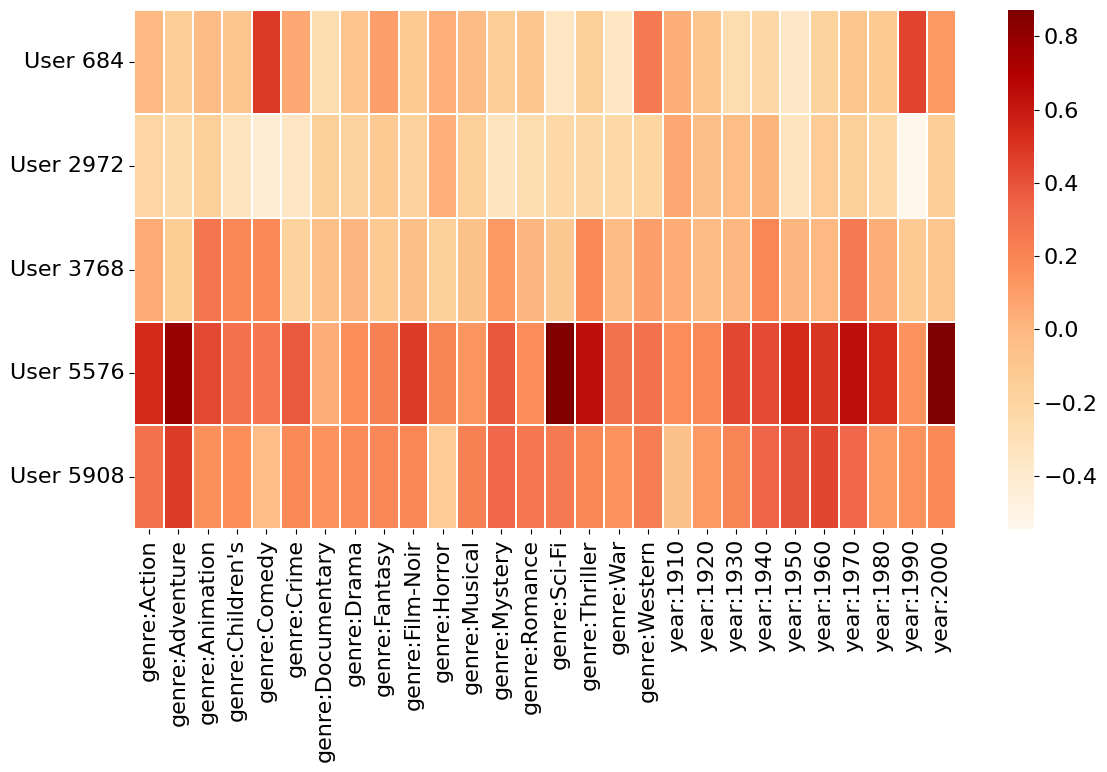

In [ ]:
rnd = random.Random(42)

target_ids = []
for id, d in dataset_center.seq_metadata.items():
    if d["gender"] == "M" and d["age"] == "25-34" and d["occupation"] == "college/grad student":
        target_ids.append(int(id))

rnd.shuffle(target_ids)

target_ids = sorted(target_ids[:5])
item_keys = dataset_center.item_meta_le.classes_
seq_keys = list(map(lambda s: "User " + str(s), target_ids))

data = np.zeros((len(seq_keys), len(item_keys)))
for i, id in enumerate(target_ids):
    seq_index = dataset_center.seq_le.transform([str(id)])[0]
    df = analyze_seq(seq_index)
    for j, item_key in enumerate(item_keys):
        data[i][j] = df[(df.seq == str(id)) & (df.item == item_key)].similarity.values[0]

fig, ax = util.visualize_heatmap(data, seq_keys, item_keys)
fig.tight_layout()
fig.savefig("data/fig_heatmap_user_item_meta.pdf")

In [10]:
seq_keys = ["309", "gender:M", "age:25-34", "occupation:college/grad student"]
item_keys = dataset_center.item_meta_le.classes_

df = analyze_seq(2322)

data = np.zeros((len(seq_keys), len(item_keys)))
for i, seq_key in enumerate(seq_keys):
    for j, item_key in enumerate(item_keys):
        data[i][j] = df[(df.seq == seq_key) & (df.item == item_key)].similarity.values[0]

seq_keys = ["User 309", "gender:M", "age:25-34", "occupation:\ncollege/grad student"]
fig, ax = visualize_heatmap(data, seq_keys, item_keys)
fig.tight_layout()
fig.savefig("data/fig_heatmap_user_all_item_meta.pdf")

IndexError: index 0 is out of bounds for axis 0 with size 0